# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Основные понятия и описание данных

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


Целевой признак:
- Price — цена (евро)

# Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

## Подготовка данных

### Библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [4]:
# %%capture

# !pip install category_encoders
# import category_encoders as ce

# !pip install catboost
from catboost import CatBoostRegressor

# !pip install lightgbm
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [5]:
# импортируем функцию предобработки
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
# from sklearn.utils import shuffle
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# импортируем функции машинного обучения
from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error as mse
# from sklearn.model_selection import cross_val_score

# from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier

In [6]:
import category_encoders as ce

### Откроем и изучим файлы

#### Общая информация

In [7]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [8]:
# ProfileReport(df)

In [9]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


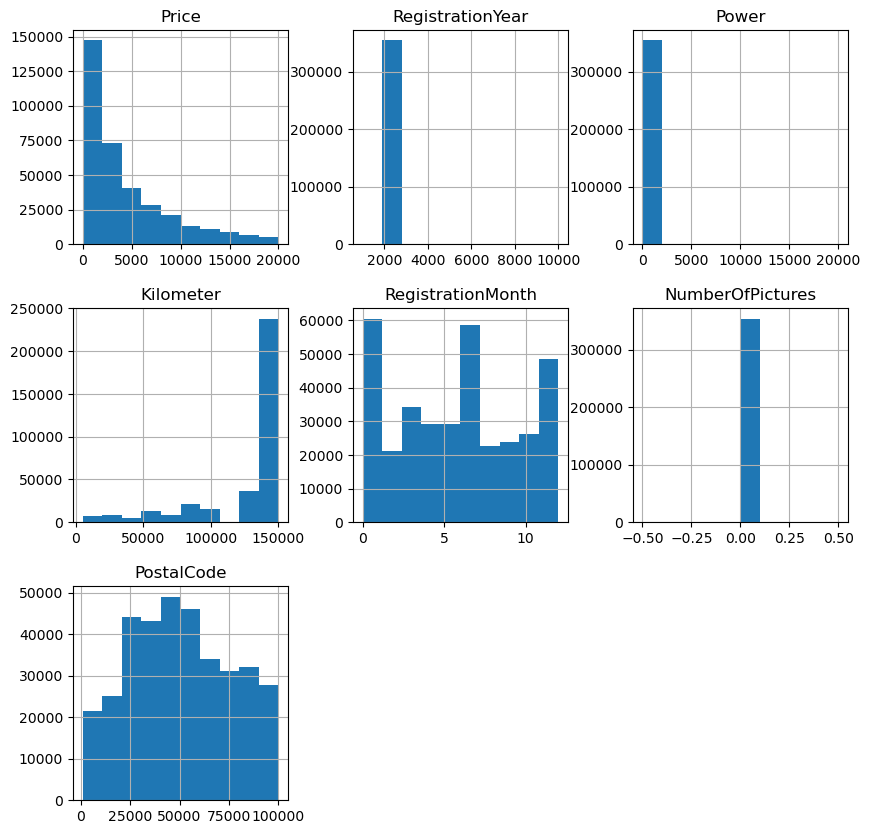

In [10]:
df.hist(figsize=(10, 10))
plt.show()

#### Замена названий столбцов

In [11]:
# Приведем названия столбцов к змеиному регистру
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [12]:
df.columns = ['Date_Crawled', 'Price', 'Vehicle_Type', 'Registration_Year', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'Registration_Month', 'Fuel_Type', 'Brand',
       'Repaired', 'Date_Created', 'Number_Of_Pictures', 'Postal_Code',
       'Last_Seen']
df.columns = df.columns.str.lower()

In [13]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Работа с пропусками

In [14]:
round(df.isna().sum() / len(df) * 100, 2)

date_crawled           0.00
price                  0.00
vehicle_type          10.58
registration_year      0.00
gearbox                5.60
power                  0.00
model                  5.56
kilometer              0.00
registration_month     0.00
fuel_type              9.28
brand                  0.00
repaired              20.08
date_created           0.00
number_of_pictures     0.00
postal_code            0.00
last_seen              0.00
dtype: float64

Пропуски в столбце `vehicle_type` заменим константным значением, тк не мы не может достаточно точно определить тип кузова.

Со столбцами `gearbox`, `model`, `fuel_type` и `repaired` поступим также.

In [15]:
fillna_coll = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']

for i in range(len(fillna_coll)):
    df[fillna_coll[i]] = df[fillna_coll[i]].fillna('unknown')

#### Работа с дубликатами

Определим наличие явных дубликатов и удалим их.

In [16]:
df.duplicated().sum()

4

In [17]:
df = df.drop_duplicates()

Изучим датафрейм на наличие неявных дубликатов.

In [18]:
df['vehicle_type'].unique()

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [19]:
df['gearbox'].value_counts()

manual     268249
auto        66283
unknown     19833
Name: gearbox, dtype: int64

In [20]:
df['fuel_type'].value_counts()

petrol      216349
gasoline     98719
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

`lpg` и `cng` считаются обозначением сжиженного углеводородного газа, их можно объединить

`petrol` - обозначение бензина в Англии

`gasoline` - обозначение бензина в Америке  
*В Крыму "газолин" - это бензин тоже :)*

`gasoline` и `petrol` можно объединить

In [21]:
df.loc[df['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'
df.loc[df['fuel_type'] == 'cng', 'fuel_type'] = 'lpg'

In [22]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [23]:
len(df['model'].unique())

251

In [24]:
len(df['model'].str.lower().unique())

251

Если в столбце `model` присутствуют неявные дубликаты их будет сложно определить, однако случаи должны быть единичны.

Для корректорй проверки может подойти отдельный датафрейм со связью.

#### Удалим неинформативные столбцы

Для определения корреляций проведем прямое кодирование 

Используем OrdinalEncoder, тк он быстрее других подобных

In [25]:
# encoder = OrdinalEncoder() 

In [26]:
# encoder.fit(df) 

In [27]:
# data_ordinal = pd.DataFrame(encoder.transform(df), columns=df.columns) 

Оценим корреляцию признаков с целевым.

In [28]:
# corr = data_ordinal.corr(min_periods=50)
# corr_price = pd.DataFrame(corr['price']).sort_values(by='price', ascending=False)

In [29]:
# corr_price.style.background_gradient(cmap='coolwarm')

Сочтем столбцы `date_crawled`, `date_created`, `number_of_pictures`, `last_seen` и `postal_code` неинформативными, остальные изучим позднее.

In [30]:
drop_coll = ['date_crawled', 'date_created', 'postal_code', 'number_of_pictures', 'last_seen']

In [31]:
df_clear = df.drop(drop_coll, axis=1)

In [32]:
# del data_ordinal, encoder, corr, corr_price

#### Рассмотрим выбивающиеся значения

Из пунта 1.2.1 видно, что присутствуют выбивающиеся значения в столбцах `registration_year` и `power`. Рассмотрим их подробнее.

In [33]:
sorted(df_clear['registration_year'].unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

Оставим значния, похожие на правду и актуальные для нас(с 1950 до 2019)

In [34]:
MIN_YEAR = 1950
MAX_YEAR = 2016

In [35]:
df_clear = df_clear.loc[(df_clear['registration_year'] >= MIN_YEAR) & (df_clear['registration_year'] <= MAX_YEAR)]

In [36]:
df['date_crawled'].max()

'2016-04-07 14:36:58'

In [37]:
sorted(df_clear['power'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [38]:
df_clear['power'].describe()

count    339589.000000
mean        111.045163
std         186.900896
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

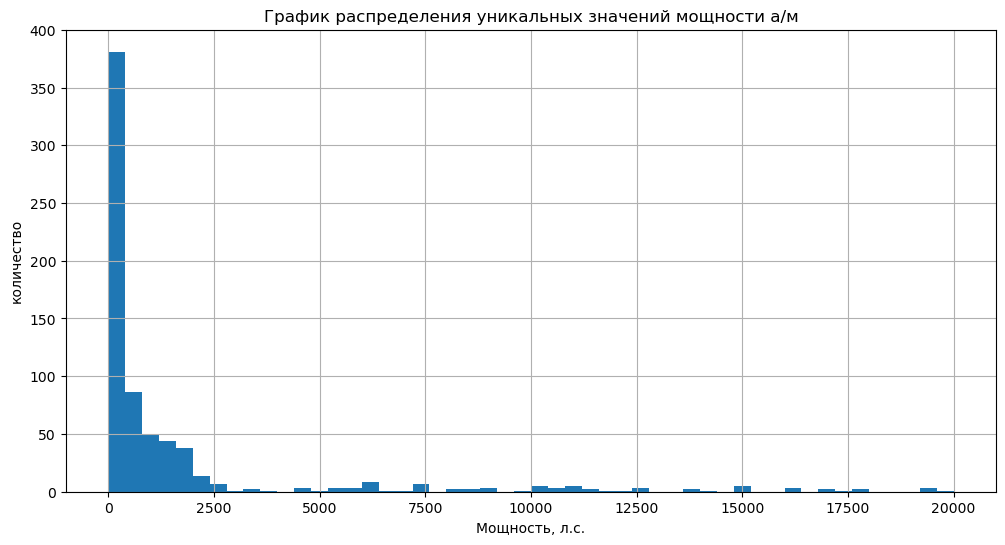

In [39]:
(pd.Series(
    list(df_clear.power.unique()))
    .sort_values(ascending=False)
    .plot(kind='hist', figsize=(12,6), grid=True, bins=50)
)

plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('количество')
plt.xlabel('Мощность, л.с.')
plt.show()

In [40]:
df_clear = df_clear.query('power > 15 & power < 2500')

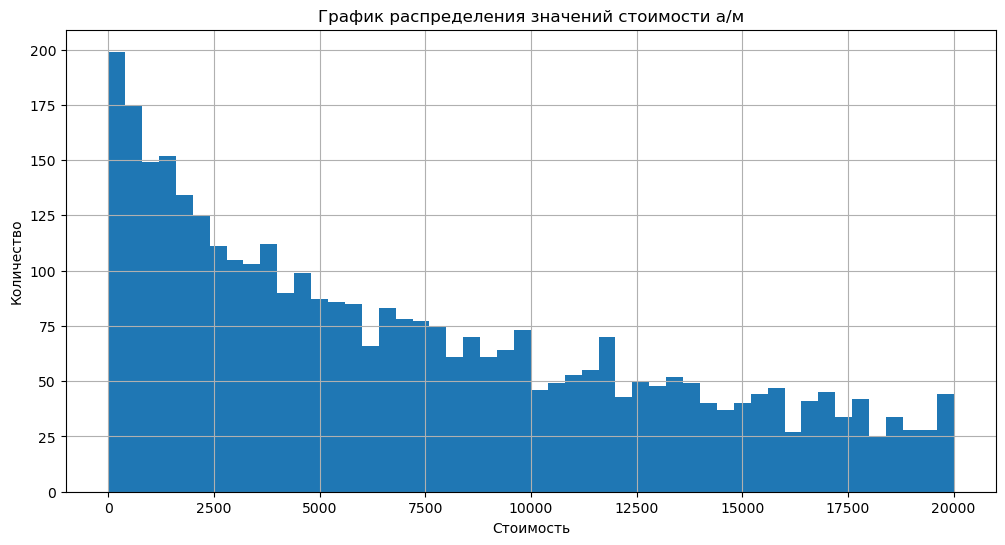

In [41]:
(pd.Series(
    list(df_clear.price.unique()))
    .sort_values(ascending=False)
    .plot(kind='hist', figsize=(12,6), grid=True, bins=50)
)

plt.title('График распределения значений стоимости а/м')
plt.ylabel('Количество')
plt.xlabel('Стоимость')
plt.show()

In [42]:
df_clear.loc[df_clear['price'] <= 100]['price'].count()

8185

Распределение Пуассона выглядит нормально, однако следует удалить значения ниже 100 евро, поскольку нас такие случаи не интересуют. Это могут быть разбитые машины или владельцы настроены на обмен.

In [43]:
df_clear = df_clear.query('price > 100')

#### Именение типа данных

In [44]:
# df_clear['last_seen'] = pd.to_datetime(df_clear['last_seen'], format='%Y-%m-%d %H:%M:%S')

#### Разбиение данных на выборки

In [45]:
features = df_clear.drop('price', axis=1)
target = df_clear['price']

In [46]:
RANDOM_STATE = 42

In [47]:
# features_train, features_test, target_train, target_test = train_test_split(
#     feature, target, test_size=0.25, random_state=RANDOM_STATE)

In [48]:
# отделим 25% для тестовой
features_tv, features_test, target_tv, target_test = train_test_split(
    features, target, test_size=0.2, train_size=0.8, random_state=RANDOM_STATE)

# оставшиеся данные разделим в соответствии с ожидаемыми размерами выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features_tv, target_tv, test_size = 0.25, train_size =0.75, random_state=RANDOM_STATE)

#### Анализ категориальных признаков, кодирование

<!-- Проведем прямое кодирование, поскольку нам важно время обучения модели. Однако этот метод имеет ряд недостатков, например, неворзможно обучать на тренировочной выборке, а потом уже обученные на них скелеры, кодера и пр. применять к валидационной и тестовой выборке.

Однако, в данном проекте это не имеет большое значение.

Возникающий после применения дисбаланс устраним масштабированием данных. -->

<!-- Проведем таргетное кодирование, для уменьшения нагрузки при обучении модели и устранении проблем OrdinalEncoder при очуении моделей для задач регрессии. -->

Проведем кодирование c помощью обобщенной линейной смешанной модели(GLMM), для значительного уменьшения нагрузки при обучении модели с техникой ОНЕ и устранении проблем OrdinalEncoder при обучении моделей для задач регрессии.

In [49]:
glmm_encoder = ce.GLMMEncoder(binomial_target=False)
# binomial_target = True (for Classification)
# binomial_target = False (for Regression)

In [50]:
%%time

glmm_encoder.fit(features_train, target_train)

CPU times: total: 15.5 s
Wall time: 4.54 s


GLMMEncoder(binomial_target=False,
            cols=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand',
                  'repaired'])

In [51]:
features_train_enc = glmm_encoder.transform(features_train)
features_valid_enc = glmm_encoder.transform(features_valid)
features_test_enc = glmm_encoder.transform(features_test)
features_train_enc.describe()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
count,176805.000000,176805.000000,176805.000000,176805.000000,176805.000000,176805.000000,176805.000000,176805.000000,176805.000000,176805.000000
mean,-496.864568,2002.838585,4.241375,121.606651,-1247.521118,128215.604762,6.002907,-900.953315,27.606037,1241.326977
std,1532.747202,6.487558,1196.234621,64.677262,2442.302477,36806.342619,3.581306,508.201234,1530.066375,1200.477863
min,-2785.100255,1950.000000,-1830.809297,16.000000,-5264.916646,5000.000000,0.000000,-2956.608153,-3670.373653,-1430.084298
25%,-2449.505070,1999.000000,-555.536449,77.000000,-2826.761064,125000.000000,3.000000,-778.762709,-1299.441534,1902.718300
50%,-382.265365,2003.000000,-555.536449,111.000000,-1599.743455,150000.000000,6.000000,-778.762709,-14.260917,1902.718300
75%,-198.282435,2007.000000,-555.536449,150.000000,50.080015,150000.000000,9.000000,-778.762709,1462.016616,1902.718300
max,4025.624746,2016.000000,2386.346486,2461.000000,10990.192133,150000.000000,12.000000,4239.394903,7715.311166,1902.718300


In [52]:
# encoder_targ = ce.TargetEncoder(return_df=True)
# X_train_loo = encoder_targ.fit_transform(features_train, target_train)
# X_train_loo.dtypes
# 
# X_valid_loo = encoder_targ.transform(features_valid)
# X_valid_loo.head()

#### Масштабирование данных

In [53]:
# Удаление предупреждения
pd.options.mode.chained_assignment = None

# Числовые признаки
numeric_num = ['registration_year', 'power', 'kilometer', 'registration_month']
# Категориальные признаки
numeric_cat = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# Числовые признаки кодированных данных
numeric_enc = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired']

In [54]:
%%time

# Масштабирование не кодированных данных
# Создадим объект структуры и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train[numeric_num])

features_train[numeric_num] = scaler.transform(features_train[numeric_num])
features_valid[numeric_num] = scaler.transform(features_valid[numeric_num])
features_test[numeric_num] = scaler.transform(features_test[numeric_num])

CPU times: total: 46.9 ms
Wall time: 36 ms


In [55]:
features_train

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
157261,wagon,-0.745827,auto,0.732769,unknown,0.591867,-0.000812,petrol,audi,unknown
353689,sedan,0.179022,manual,0.006082,carisma,-1.038292,1.674559,petrol,mitsubishi,no
303815,small,-1.054111,manual,-1.029834,ka,0.591867,1.395331,petrol,ford,yes
15110,wagon,0.795589,auto,0.284387,golf,-1.309985,0.836874,petrol,volkswagen,no
229365,small,-0.591686,manual,-0.952527,2_reihe,-0.087366,-0.559269,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...
151006,wagon,0.795589,manual,-0.194917,focus,0.591867,0.278417,petrol,ford,no
138133,convertible,-0.899969,manual,0.222542,slk,0.591867,0.278417,petrol,mercedes_benz,no
279317,sedan,1.103872,manual,-0.256763,golf,-0.766598,-0.559269,petrol,volkswagen,no
117198,small,-0.591686,manual,-0.720605,golf,-0.766598,1.395331,petrol,volkswagen,no


In [55]:
%%time

# Масштабирование кодированных данных
# Создадим объект структуры и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train_enc[numeric_enc])

features_train_enc[numeric_enc] = scaler.transform(features_train_enc[numeric_enc])
features_valid_enc[numeric_enc] = scaler.transform(features_valid_enc[numeric_enc])
features_test_enc[numeric_enc] = scaler.transform(features_test_enc[numeric_enc])

CPU times: total: 78.1 ms
Wall time: 77.8 ms


In [56]:
features_train_enc
features_test_enc.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
158902,0.194802,-0.283403,1.991342,1.088382,0.773416,0.591867,-0.280040,0.240438,1.148550,0.550942
145969,0.074767,-0.591686,-0.467951,-0.952527,-0.452838,-0.087366,-0.000812,0.240438,-2.416882,0.550942
72846,-1.273952,-0.283403,-0.467951,-0.952527,-1.182169,-1.581678,-0.559269,0.240438,-0.218493,0.550942
277526,0.194802,-0.899969,-0.467951,-0.720605,-0.837055,0.591867,1.395331,0.240438,-0.027363,0.550942
151097,0.581819,0.487306,-0.467951,-0.256763,0.732708,0.591867,-0.000812,0.240438,-0.383915,0.550942


### Вывод по итогу подготовки данных

- приведены названия столбцов к змеиному регистру
- в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired` устранены пропуски;
- проведена работа с явными и неявными дубликатами;
- обработаны выбросы;

Удалены неинформативные признаки: `number_of_pictures`, `date_created`, `postal_code`, `date_crawled`

---

Проведено:
- разбиение на выборки
- кодирование категориальных признаков
- масштабирование данных

`df_clear` - предобработанная база данных.

`target_train`, `target_valid`, `target_test` - выборки с целевым признаком.

`features_test`, `features_test`, `features_valid` - признаки. Данные для моделей, способных воспринимать текст.
 
`features_train_enc`, `features_test_enc`, `features_valid_enc` - признаки. Кодированные и масштабированные данные.

## Обучение моделей

*Переборы урезаны в целях экономии времени после подбора гиперпараметров*

In [57]:
# Функция для подсчета RMSE
def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.

Воспользуемся следующими моделями:
- Линейная регрессия;
- Случайный лес;
- CatBoost;
- LightGBM;

Создадим вспомогательный класс для фиксации результатов моделей

In [58]:
import time

class Helper:
    def __init__(self, name, model): # инициализация модели
        self.name = name
        self.model = model
        
    def fit(self, feature, target): # обучение
        start = time.time()
        self.model.fit(feature, target)
        end = time.time()
        self.fit_time = end - start
        
    def predict(self, feature, target): # предсказание
        start = time.time()
        predicted = self.model.predict(feature)
        end = time.time()
        self.predicted_time = end - start
        self.rmse = round(rmse(target, predicted), 2)
        
    def getResult(self): # фиксация результатов модели
        return self.name, self.fit_time, self.predicted_time, self.rmse

In [59]:
result = []

### Линейная регрессия

In [60]:
model_lr = LinearRegression()
model_lr_helper = Helper('Linear regression', model_lr)
model_lr_helper.fit(features_train_enc, target_train)
model_lr_helper.predict(features_valid_enc, target_valid)

In [61]:
result.append(model_lr_helper.getResult())

### Случайный лес

In [62]:
# %%time

# Перебор случайного леса
# parameters = {'n_estimators': range(100,201,50),'max_depth': range(15,31,5),
#               'min_samples_leaf': range(1,5,5), 'min_samples_split': range(5,9,3)}

# model = RandomForestRegressor()
# grid = GridSearchCV(model, parameters, cv=3, scoring='neg_mean_squared_error')
# grid.fit(features_train_enc, target_train)

# grid.best_params_


# Получим следующие результаты:

# {'max_depth': 20,
#  'min_samples_leaf': 1,
#  'min_samples_split': 8,
#  'n_estimators': 200}

In [63]:
DEPTH = 20
SAMPLES_LEAF = 1
SAMPLES_SPLIT = 8
N_ESTINATORS = 200

# Для оценки времени с другими данными
DEPTH_FAST = 7
SAMPLES_LEAF_FAST = 3
SAMPLES_SPLIT_FAST = 2
N_ESTINATORS_FAST = 10

In [64]:
%%time

model_rfr_fast = RandomForestRegressor(max_depth=DEPTH_FAST, min_samples_leaf=SAMPLES_LEAF_FAST,
                                  min_samples_split=SAMPLES_SPLIT_FAST, n_estimators=N_ESTINATORS_FAST,
                                  random_state=RANDOM_STATE)
model_rfr_helper_fast = Helper('Random Forest Fast', model_rfr_fast)
model_rfr_helper_fast.fit(features_train_enc, target_train)
model_rfr_helper_fast.predict(features_valid_enc, target_valid)

CPU times: total: 2.12 s
Wall time: 1.7 s


In [65]:
result.append(model_rfr_helper_fast.getResult())

In [66]:
%%time

model_rfr = RandomForestRegressor(max_depth=DEPTH, min_samples_leaf=SAMPLES_LEAF,
                                  min_samples_split=SAMPLES_SPLIT, n_estimators=N_ESTINATORS,
                                  random_state=RANDOM_STATE)
model_rfr_helper = Helper('Random Forest', model_rfr)
model_rfr_helper.fit(features_train_enc, target_train)
model_rfr_helper.predict(features_valid_enc, target_valid)

CPU times: total: 1min 22s
Wall time: 1min 22s


In [67]:
result.append(model_rfr_helper.getResult())

### CatBoost

In [68]:
%%time

cbr = CatBoostRegressor(loss_function='RMSE', silent=True, cat_features=numeric_cat,
                        learning_rate=0.4, random_seed=RANDOM_STATE)
cbr_params = {'iterations': range(180, 181, 20),'depth': range(11,14,3)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring='neg_mean_squared_error')
grid_cbr.fit(features_train, target_train);

grid_cbr.best_params_

# {'depth': 11, 'iterations': 180}

CPU times: total: 4min 2s
Wall time: 57.3 s


{'depth': 11, 'iterations': 180}

In [69]:
model_cbr = grid_cbr.best_estimator_
model_cbr_helper = Helper('CatBoost', model_cbr)
model_cbr_helper.fit(features_train, target_train)

In [70]:
model_cbr_helper.predict(features_valid, target_valid)
result.append(model_cbr_helper.getResult())

### LightGBM

In [71]:
%%time

gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, learning_rate=0.4, seed=RANDOM_STATE, force_row_wise='true')
gbm_params = {'n_estimators': range(180, 181, 20), 'num_leaves': range(60,105,10)}

grid_gbm = GridSearchCV(gbm, gbm_params, cv=3, scoring='neg_mean_squared_error')
grid_gbm.fit(features_train_enc, target_train);

grid_gbm.best_params_

# {'n_estimators': 180, 'num_leaves': 80}

CPU times: total: 46.8 s
Wall time: 11.9 s


{'n_estimators': 180, 'num_leaves': 80}

In [72]:
model_gbm = grid_gbm.best_estimator_
model_gbm_helper = Helper('LightGBM', model_gbm)
model_gbm_helper.fit(features_train_enc, target_train)

In [73]:
model_gbm_helper.predict(features_valid_enc, target_valid)
result.append(model_gbm_helper.getResult())

### Вывод по итогу обучения моделей

- Модель Линейной регрессии хоть и быстрая, но слишком большая погрешность.

- Модель случайного леса удобна ввиду быстрого перебора гиперпараметров

- Модели CatBoost и LightGBM имеют схожее время обучения при переборе гиперпараметров. Однако, LightGBM немного быстрее.

## Анализ моделей

In [74]:
pd.DataFrame(result, columns=['Модель', 'Время обучения', 'Время предсказания', 'RMSE'])

,Модель,Время обучения,Время предсказания,RMSE
0,Linear regression,0.054477,0.000000,2902.03
1,Random Forest Fast,1.670619,0.031246,2081.59
2,Random Forest,80.649517,2.147899,1561.28
3,CatBoost,15.649012,0.148718,1579.96
4,LightGBM,0.763342,0.148904,1564.80


Исходя из требований заказчика:
- качество предсказания;
- время обучения модели;
- время предсказания модели;

рекомендуется отдать предпочтение модели LightGBM или модели CatBoost

Модель Random Forest также показала хорошее качество предсказания, однако, она может пригодиться только в случае неограниченного запаса времени :)

### Тестирование модели

In [75]:
test_result = []

model_gbm_helper.predict(features_test_enc, target_test)
test_result.append(model_gbm_helper.getResult())

pd.DataFrame(test_result, columns=['Модель', 'Время обучения', 'Время предсказания', 'RMSE'])

,Модель,Время обучения,Время предсказания,RMSE
0,LightGBM,0.763342,0.155601,1559.83


### Проверка модели на адекватность

In [76]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)

DummyRegressor()

In [77]:
mean_predictions = dummy_regr.predict(features_test)
mean_rmse = rmse(target_test, mean_predictions)

In [78]:
print('RMSE модели на выборке средних значений составляет:', mean_rmse)

RMSE модели на выборке средних значений составляет: 4619.2894601265325


**В данном проекте я бы отдал предпочтение модели LightGBM ввиду лучшей скорости обучения и предсказания при относительно небольших погрешностях, в сравнении с другими моделями.**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей